# Analog circuit simulation using NgSpice in Python Jupyter

By Shuo Chen (chenshuo_at_chenshuo.com)

Latest notebook: https://github.com/chenshuo/notes/blob/master/notebooks/AnalogCircuits.ipynb

In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

In [2]:
# NgSpice
import ngspyce as ng

ERROR:ngspyce.sharedspice:Note: can't find the initialization file spinit.


In [3]:
# Circuitikz
# pip install git+git://github.com/mkrphys/ipython-tikzmagic.git

%load_ext tikzmagic

In [35]:
ng.circ('''
  V1 vcc 0 15
  R1 vcc b 47k
  R2 b 0 4k
''')
ng.operating_point()

{'v1#branch': array([-0.00029412]),
 'b': array([1.17647059]),
 'vcc': array([15.])}

In [37]:
b = 4 / (4 + 47) * 15
print(b)

1.1764705882352942


In [38]:
print(b - ng.vector('b'))

[-2.22044605e-16]


# Setting Q-point of basic CE amplifier 

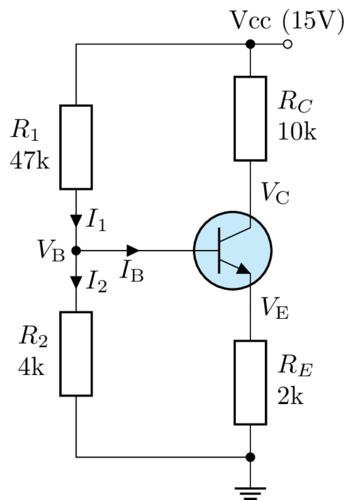

In [30]:
%%tikz -p circuitikz -s 400,500
\ctikzset{european resistors, transistors/arrow pos=end, transistors/fill=cyan!20}
\newcommand{\ui}[1]{\ensuremath{I_\mathrm{#1}}}
\newcommand{\uv}[1]{\ensuremath{V_\mathrm{#1}}}
\draw (0, 0) node [npn, tr circle] (Q) {};
\draw (Q.C) to [R, l2_={$R_C$ and 10k}] ++(0, 2) coordinate (Vcc)
  to [short, -o] ++(0.5, 0) node [above] {Vcc (15V)}; 
\draw (Q.B) to [short, -*, i<={$\ui{B}$}] ++ (-1.5, 0) coordinate (B);
\draw (Q.E) node [right] {$\uv{E}$}
to [R, l2={$R_E$ and 2k}, -*] ++(0, -2) coordinate (G) node[ground]{};
\draw (B) to [R, l2={$R_1$ and 47k}, i<_={$I_1$}] (B|-Vcc) to [short, -*] (Vcc);
\draw (B) to [R, l2_={$R_2$ and 4k}, i>^={$I_2$}] (B|-G) to [short] (G);
%\draw (B) to [C, -o] ++(-1.5, 0) node [left] {Vin};
\draw (Q.C) node [right] {$\uv{C}$} ; %to [short, *-o] ++(0.7, 0) node[above] (O) {Vout};
\draw (B) node [left] {$\uv{B}$};

## Operating point

In [39]:
ng.circ('''
  V1 vcc 0 15
  R1 vcc b 47k
  R2 b 0 4k
  Q1 c b e npn
  Rc vcc c 10k
  Re e 0 2k
  .model npn npn
  .options savecurrents
''')
ng.operating_point()

{'@re[i]': array([0.00021704]),
 '@rc[i]': array([0.0002149]),
 '@q1[is]': array([1.28510456e-11]),
 '@q1[ib]': array([2.14894329e-06]),
 '@q1[ie]': array([-0.00021704]),
 '@q1[ic]': array([0.0002149]),
 '@r2[i]': array([0.00029214]),
 '@r1[i]': array([0.00029429]),
 'v1#branch': array([-0.00050918]),
 'e': array([0.43408875]),
 'c': array([12.85104557]),
 'b': array([1.16854899]),
 'vcc': array([15.])}

In [31]:
Vb = ng.vector('b')
Ve = ng.vector('e')
Ib = ng.vector('@q1[ib]')
Ic = ng.vector('@q1[ic]')
print('Vbe = %.3f V' % (Vb - Ve))
print('Ib = %.3f μA' % (Ib * 1e6))
print('beta = %.0f' % (Ic / Ib))

Vbe = 0.734 V
Ib = 2.149 μA
beta = 100


## DC sweep

In [44]:
ng.cmd('dc r1 10k 100k 100')
print(ng.vector_names())
r1 = ng.vector('res-sweep')
Vb = ng.vector('b')
Ve = ng.vector('e')
Vc = ng.vector('c')
Ib = ng.vector('@q1[ib]')
Ic = ng.vector('@q1[ic]')
plt.plot

['@re[i]', '@rc[i]', '@q1[is]', '@q1[ib]', '@q1[ie]', '@q1[ic]', '@r2[i]', '@r1[i]', 'v1#branch', 'e', 'c', 'b', 'vcc', 'res-sweep']


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

(1.0, 16.0)

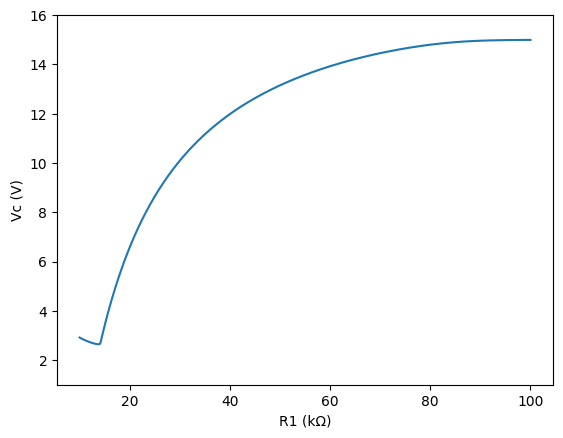

In [53]:
plt.plot(r1/1e3, Vc)
plt.xlabel('R1 (kΩ)')
plt.ylabel('Vc (V)')
plt.ylim(1, 16)

In [55]:
ng.cmd('alter r1 22k')
ng.operating_point()

{'@re[i]': array([0.00075775]),
 '@rc[i]': array([0.00075025]),
 '@q1[is]': array([7.49752406e-12]),
 '@q1[ib]': array([7.50285045e-06]),
 '@q1[ie]': array([-0.00075779]),
 '@q1[ic]': array([0.00075029]),
 '@r2[i]': array([0.00057057]),
 '@r1[i]': array([0.00057808]),
 'v1#branch': array([-0.00132832]),
 'e': array([1.51550012]),
 'c': array([7.49752406]),
 'b': array([2.28229933]),
 'vcc': array([15.])}

## Temperature sweep

Text(0, 0.5, 'Ic (mA)')

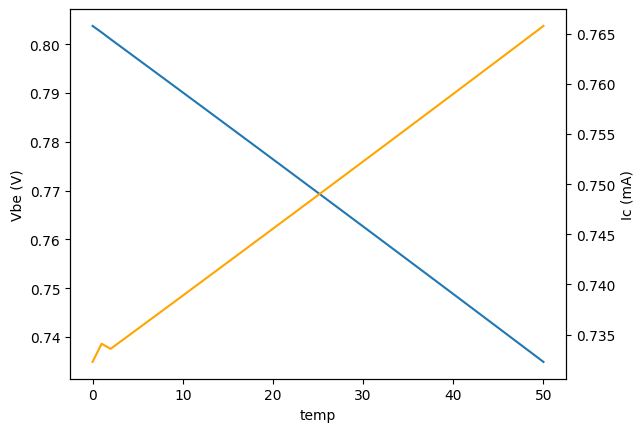

In [56]:
ng.cmd('dc temp 0 50 1')
temp = ng.vector('temp-sweep')
Ic = ng.vector('@q1[ic]')
Vb = ng.vector('b')
Ve = ng.vector('e')
fig, ax = plt.subplots()
plt.plot(temp, Vb-Ve, label='Vbe')
plt.xlabel('temp')
plt.ylabel('Vbe (V)')
ax2 = ax.twinx()
plt.plot(temp, Ic*1e3, 'orange', label='Icq')
plt.ylabel('Ic (mA)')